# 매개변수 및 맞춰야하는것들

1. transformer encode input shape(source_seq, batch, feature)

2. trnasformer decode input shape(target_seq, batch, feature)

encode,decode 둘다 feature = d_model과 같은 차원이어야함

output.shape(target_seq, batch, feature)



임베딩과 포지셔닝 인코딩은 transformer넣기 전에 맞춰야하고 그 앞에는 따로 만들수 있음


generate_square_subsequent_mask =  seq사이즈로 선언하고 이것의 의미는

generate_square_subsequent_mask(4) 기준

[[0, -inf, -inf ,-inf\],

 [0, 0, -inf, -inf\],

 [0, 0, 0, -inf\],

 [0, 0, 0, 0\]\]
으로 선언되는것임

tranformer에 들어가는 인풋은 

src, tgt, src_mask, tgt_mask 가 있고 각각은 다음과 같다

> src = encode_data

> tgt = decode_data

> src_mask = encode_data의 마스크

> tgt_mask = decode_data의 마스크





## 만들어야하는것

train, predict , 코드는 찾음

embedding, tokenizer의 경우 좀더 찾아봐ㅑ함


## 확인된것

transformer의 input , output의 상태 , 어떻게 변형시켜야하는지






In [1]:
print(1)

1


![](img\transformer_attention_overview.png)

## Import Modules

In [4]:
import mediapipe as mp
import numpy as np
import time
import cv2
import torch
import math
import pandas as pd
import os
import time
# import gensim

## load data

In [5]:
def load_tensor(dir_names):
    '''
    tensor 가져오는 방식을 csv에서 가져온 번호에서 부터 불러오도록 설정
    output 에 nums는 현재 가져온곳의 한글값을 표현하기 위해서 
    '''
    lt_list = []
    rt_list = []
    ft_list = []
    pt_list = []
    nums = []
    for i, dir_name in enumerate(dir_names):
        path = 'output/tensor/'+dir_name[:-4]
        if not (os.path.isdir(path)):
            continue
        lt_list.append(torch.load(path+'/left_hand.pt'))
        rt_list.append(torch.load(path+'/right_hand.pt'))
        ft_list.append(torch.load(path+'/face.pt'))
        pt_list.append(torch.load(path+'/pose.pt'))
        nums.append(i)

    return lt_list, rt_list, ft_list, pt_list, nums

In [6]:

num_csv1 = pd.read_csv("output\csv\KETI-2017-SL-0_10480-v2_1_num.csv")

dir_names = num_csv1['파일명']
kors=num_csv1['한국어']

In [7]:
dir_names.shape

(2020,)

In [8]:
dir_names[45:55]

45    KETI_SL_0000000046.MOV
46    KETI_SL_0000000047.MOV
47    KETI_SL_0000000048.MOV
48    KETI_SL_0000000049.MOV
49    KETI_SL_0000000050.MOV
50    KETI_SL_0000000051.MOV
51    KETI_SL_0000000052.MOV
52    KETI_SL_0000000053.MOV
53    KETI_SL_0000000054.MOV
54    KETI_SL_0000000055.MOV
Name: 파일명, dtype: object

In [9]:
lt_list,rt_list,ft_list,pt_list,nums = load_tensor(dir_names)

In [10]:
t = pt_list[0]

In [11]:
lt_list[0].shape

torch.Size([141, 21, 3])

In [12]:
len(lt_list)

871

## Encoder Input Preprocessing

In [13]:
def pipe(t):
    return torch.nn.utils.rnn.pad_sequence(list(map(
            lambda x: x.view(-1,x.shape[1]*x.shape[2]),t)))

In [15]:

lt_list = pipe(lt_list)
rt_list = pipe(rt_list)
ft_list = pipe(ft_list)
pt_list = pipe(pt_list)

# seq, batch , feature 순

In [16]:
lt_list.shape, rt_list.shape, ft_list.shape, pt_list.shape

(torch.Size([208, 871, 63]),
 torch.Size([208, 871, 63]),
 torch.Size([208, 871, 1404]),
 torch.Size([208, 871, 99]))

In [17]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)        

        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [18]:
d_model = 400
cat_data= torch.cat((lt_list,rt_list,pt_list),axis = 2)
embedding_data = torch.nn.Linear(cat_data.shape[2],d_model)(cat_data)
positioning_embedding_data = PositionalEncoding(d_model)(embedding_data)
# concat을 진행하고 이를 DNN에 통과시켜서 입력 shape를 맞춤

In [19]:
cat_data.shape , embedding_data.shape , positioning_embedding_data.shape

(torch.Size([208, 871, 225]),
 torch.Size([208, 871, 400]),
 torch.Size([208, 871, 400]))

## Docoder Input Preprocessing

In [20]:
answer = kors[nums]
print(answer.shape, answer.unique().size)
answer[40:60]

(871,) 54


40     40
41     41
42     42
43     43
44     44
45     45
46     46
47     47
48     48
49     49
50     50
101     0
102     1
103     2
104     3
105     4
106     5
107     6
108     7
109     8
Name: 한국어, dtype: int64

In [21]:
# tokenizer, pad_sequence
sos_data = torch.LongTensor(np.zeros(answer.size)+answer.unique().size).unsqueeze(dim=0)
decode_data = torch.LongTensor(answer).unsqueeze(dim=0)
decode_data = torch.cat((sos_data,decode_data),axis=0)

In [22]:
decode_data[:,:10]

tensor([[54, 54, 54, 54, 54, 54, 54, 54, 54, 54],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]])

In [23]:
sos_data.shape , decode_data.shape 
# seq, batch

(torch.Size([1, 871]), torch.Size([2, 871]))

In [24]:
decode_emb = torch.nn.Embedding(answer.unique().size + 2,d_model) # d_model = 400
target = decode_emb(decode_data)
positioning_target = PositionalEncoding(d_model)(target)

In [25]:
target.shape, positioning_target.shape

(torch.Size([2, 871, 400]), torch.Size([2, 871, 400]))

## Y Data Preprocessing

(sos ,seq ~~~) -> (seq, eos) 

In [26]:
eos_y_data = torch.zeros(1,answer.size,answer.unique().size+2)
# (1, 153, 53)
y_data = torch.zeros(1,answer.size,answer.unique().size+2)
# (1, 153 , 53)

y_data = torch.cat((y_data,eos_y_data),axis=0)
y_data[0,torch.arange(answer.size),np.array(answer)] = 1 
#one hot vector

y_data[1,torch.arange(answer.size),-1] = 1 #eos

In [27]:
y_data.shape

torch.Size([2, 871, 56])

In [28]:
decode_data[:,100] , y_data[:,100] 
# (sos, answer)   , (answer , eos)
# sos = 51 , eos = 52

(tensor([54, 49]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1.]]))

## Test Model

In [29]:
class TransformerModel(torch.nn.Module):

    def __init__(self, input_node, d_model, nhead, nhid, nlayers,ntoken ,dropout=0.5  ):
        """
        input_node  node개수
        d_model    임배딩 차원 , model 내부의 수치
        nhead   멀티헤드 개수
        nhid    Linear 뉴런개수 = dff 
        nlayers encoder 개수 = num_layers
        ntoken  단어 개수
        """
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model

        self.encode_emb = torch.nn.Linear(input_node,d_model)# GNN으로 대체될수도 있음
        self.decode_emb = torch.nn.Embedding(ntoken,d_model)

        self.pos_encoder = PositionalEncoding(d_model, dropout) #해당하는 언어의 위치 정보

        self.transformer = torch.nn.Transformer(
                d_model = d_model, nhead = nhead, 
                num_encoder_layers = nlayers, 
                num_decoder_layers = nlayers, 
                dim_feedforward = nhid, dropout = dropout
            )

        self.decoder = torch.nn.Linear(d_model, ntoken)
        self.softmax = torch.nn.Softmax(dim=2)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


    def forward(self, src ,tgt ,src_mask = None, tgt_mask = None):
        src = torch.cat(src,axis=2)
        # lt, rt, pt 의 feature부분을 concat
        src = self.encode_emb(src)
        src = self.pos_encoder(src)

        tgt = self.decode_emb(tgt)
        tgt = self.pos_encoder(tgt)

        # print("source shape : {0} | target shape : {1}".format(src.shape,tgt.shape))
        target = self.transformer(src=src,tgt=tgt,src_mask = None, tgt_mask = None)
        output = self.decoder(target)
        output = self.softmax(output)
        return output

In [30]:
nodes = 225 # GNN이전의 노드 개수  고친다면
d_model = d_model #400
nlayers = 6 
nhead = 8 
dropout = 0.2
nhid = 2048
tokens = answer.unique().size+2 # token개수 + sos, eos
transmodel = TransformerModel(input_node = nodes,d_model= d_model,nhead = nhead,nhid=nhid,nlayers=nlayers,ntoken=tokens,dropout=dropout)

![](img\transformer_attention_overview.png)

In [32]:
(lt_list.shape, rt_list.shape, pt_list.shape)   , decode_data.shape
# encoder input , decoder input

((torch.Size([208, 871, 63]),
  torch.Size([208, 871, 63]),
  torch.Size([208, 871, 99])),
 torch.Size([2, 871]))

In [33]:
src_mask = transmodel.generate_square_subsequent_mask(lt_list.shape[0])
# src mask의 경우 다른 mask를 사용해야 하는것으로 판단됨
tgt_mask = transmodel.generate_square_subsequent_mask(decode_data.shape[0])

In [34]:
tmp_mask = transmodel.generate_square_subsequent_mask(4)

In [35]:
tmp_mask

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [36]:
src_mask.shape,tgt_mask.shape

(torch.Size([208, 208]), torch.Size([2, 2]))

In [37]:
lt_list[:,:30].shape, decode_data[:,:30].shape
# (seq, batch, feature)   (seq, batch , [feature])

(torch.Size([208, 30, 63]), torch.Size([2, 30]))

In [38]:
src = (lt_list[:,:30], rt_list[:,:30] ,pt_list[:,:30])
tgt = decode_data[:,:30]

In [39]:
src_all = (lt_list,rt_list,pt_list)
tgt_all = decode_data

## Train model

In [49]:
loss_fn =  torch.nn.BCELoss()
optimizer = torch.optim.Adam(transmodel.parameters(),lr=1e-3)

In [50]:
tmp_data = torch.LongTensor(np.zeros(answer.size)).unsqueeze(0)

pre_tgt = torch.cat((sos_data,tmp_data),dim=0)


(seq,feature) -> encoder -> decoder

(sos,aswer) - > decoder -> (answer, eos)

(sos, 0) -> decode -> (answer,eos)



![](img\transformer5_final_final.png)
![](img\룩어헤드마스크.png)

In [55]:
epochs = 200
losses = []
for i in range(epochs):
    model.train()
    start = time.time()
    print("start epoch ",end="| ")
    batch_size = 30
    tmp = int(lt_list.shape[1]/batch_size)
    for x in range(tmp):
        # if x%5 == 0:
        print(src[0].shape, tgt.shape)
        print("{0} ".format(x),end="")
        src = ( lt_list[:,x*batch_size:(x+1)*batch_size], 
                rt_list[:,x*batch_size:(x+1)*batch_size],
                pt_list[:,x*batch_size:(x+1)*batch_size]
                )
        # tgt = decode_data[:,x*batch_size:(x+1)*batch_size]
        # pre_tgt sos데이터만 들어있는 target_data
        predict = transmodel(src,pre_tgt[:,:30], src_mask=src_mask, tgt_mask=tgt_mask)
        
        loss =loss_fn(predict,y_data[:,x*batch_size:(x+1)*batch_size])
        
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    end = time.time()
    print("| end epoch: {0}\t| time: {2:.4f} |  loss : {1:6f}".format(i+1,sum(losses[i*tmp:(i+1)*tmp]),end-start))   
        

start epoch | torch.Size([208, 30, 63]) torch.Size([2, 30])
0 

KeyboardInterrupt: 

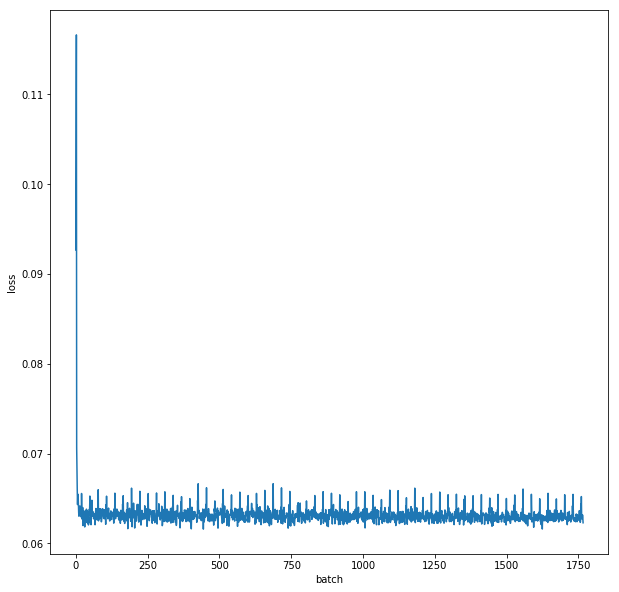

In [53]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,10))
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('batch')
plt.show()

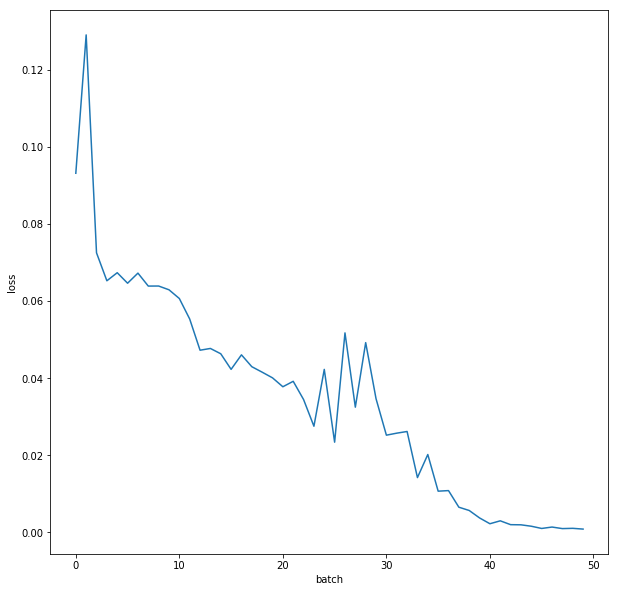

In [242]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('batch')
plt.show()

tensor([0.5036, 0.2125])


<function matplotlib.pyplot.show(*args, **kw)>

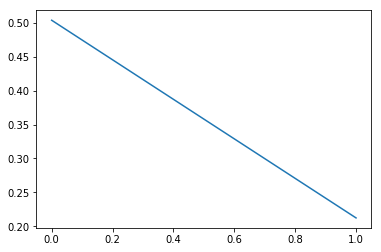

In [61]:
import matplotlib.pyplot as plt
print(pt_list[0][0,:2])
plt.plot(pt_list[0][0,:2])
plt.show

In [278]:
result = transmodel(src,tgt,src_mask=src_mask,tgt_mask = tgt_mask)

In [54]:
tgt

tensor([[54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
         54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [280]:
result.squeeze(0).max(dim=-1, keepdim=False)[1]

tensor([[43, 47, 21, 43, 43, 43, 43, 20, 43,  4, 45, 45, 43, 43, 15, 43, 10, 43,
         16, 15, 15, 43, 45, 43, 43, 43, 45,  0, 43,  8],
        [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52,
         52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]])

In [249]:
sos_data.shape

torch.Size([1, 153])

In [281]:
tmp_data = torch.LongTensor(np.zeros(153)).unsqueeze(0)

pre_tgt = torch.cat((sos_data,tmp_data),dim=0)

In [282]:
pre_tgt[:,:10]

tensor([[51, 51, 51, 51, 51, 51, 51, 51, 51, 51],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [283]:
predict = transmodel(src,pre_tgt[:,:30],src_mask=src_mask, tgt_mask=tgt_mask)

In [285]:
src[0].shape

torch.Size([191, 30, 63])

In [284]:
predict.squeeze(0).max(dim=-1, keepdim=False)[1]

tensor([[20, 24, 13, 41, 20,  8, 43, 43, 41,  9, 20, 11, 24, 20, 43,  9, 43, 38,
         43, 33, 22, 35, 41, 41, 43, 43, 20,  8,  5, 11],
        [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52,
         52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]])

<hr>

In [39]:
epochs = 100
losses = [] 
for i in range(epochs): 
    for x in range(len(lt_list)):
        predict = net(lt_list[x], rt_list[x], ft_list[x], pt_list[x])    # [1,20] ont-hot vector
        X = predict[0] # [20] 으로 변경
        Y = y_data[x]  # [20] 짜리 단위 행렬
        loss = loss_fn()(X,Y)   # Binary Cross Entropy 강화학습때 했던 log사용하는 loss 함수

        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    print("epoch : {0} , loss : {1} ".format(i,sum(losses[i*20:(i+1)*20])))

torch.Size([1, 173])

In [40]:
target = decoder_output.squeeze(0).max(dim=-1)[1]

In [42]:
decoder_output.shape

torch.Size([1, 173, 224])

In [41]:
target.shape

torch.Size([173])

In [147]:
tmp_layer = torch.nn.RNN(224,100,batch_first=True)


In [152]:
out , h  =tmp_layer(encode_train_data[:1])

In [153]:
out.shape , h.shape

(torch.Size([1, 173, 100]), torch.Size([1, 1, 100]))

In [132]:
encode_mask = transmodel.generate_square_subsequent_mask(encode_train_data.shape[0])

In [133]:
encode_mask.shape

torch.Size([20, 20])

In [148]:
tmp_tgt = torch.LongTensor(np.zeros([1,30]))


In [149]:
tmp_tgt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]])

In [157]:
predict = transmodel(src,tmp_tgt)
# np.argmax
prob = predict.squeeze(0).max(dim=-1, keepdim=False)[1]

In [156]:
tgt.shape ,tgt

(torch.Size([1, 30]),
 tensor([[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
          36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]))

In [158]:
prob

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

In [17]:
class Net(torch.nn.Module):
    '''
    현재 모델 상황
    
    구조
    left, right, face, pose 전부 각각을 rnn -> dnn 순으로 입력후
    모두 concat하고 flatten 한뒤 dnn에 입력함

    rnn -> relu -> dnn -> relu -> concat -> flat -> dnn -> softmax 순

    구성 이유
    왼손, 오른손, 얼굴, 포즈를 각각 rnn에 돌려서 특정 패턴으로 인식하고 
    해당 패턴을 조합하여 값을 내놓는다 라는 가정하에 만들었음

    제한 사항

    input shape를 고정하고
    output 또한 one hot vector로 출력되며 해당값은 1~20사이 값만 출력됨

    수정이 필요한 사항
    1.  seq사이즈를 고정하지 않고 하려 했으내 nn.Embeding은 long타입이 필요하며
        다른 방식으로 seq사이즈를 고정하는 방식을 찾이 못했음

    2.  output이 지금은 softmax를 활용한 단순 분류임 text로 변환하려는 작업이 추가적으로 필요함

    '''
    def __init__(self,seq, hidden_size, output_size):
        super(Net, self).__init__()
        # (batch_size,seq, 21*3)
        # (seq, batch, feature)
        # (batch_size,seq, 21*3)
        # (batch_size,seq, 468*3)   
        # (batch_size,seq, 33*3)

        # 임배딩이 필요함 이때 GCN사용


        self.lt = torch.nn.GRU(21*3, hidden_size,batch_first=True) # GRU 셀 구현
        self.rt = torch.nn.GRU(21*3, hidden_size,batch_first=True) # GRU 셀 구현
        self.ft = torch.nn.GRU(468*3, hidden_size,batch_first=True) # GRU 셀 구현
        self.pt = torch.nn.GRU(33*3, hidden_size,batch_first=True) # GRU 셀 구현 
        
        self.trans_encode =torch.nn.TransformerEncoder()
        self trans_decode = torch.nn.TransformerDecoder()
       

        self.relu = torch.nn.ReLU()
        self.soft = torch.nn.Softmax(dim=1)
        self.dnnlt = torch.nn.Linear(hidden_size, output_size, bias=True) # 출력층 구현
        self.dnnrt = torch.nn.Linear(hidden_size, output_size, bias=True) # 출력층 구현
        self.dnnft = torch.nn.Linear(hidden_size, output_size, bias=True) # 출력층 구현
        self.dnnpt = torch.nn.Linear(hidden_size, output_size, bias=True) # 출력층 구현

        # (1,120,20) 2400
        # (1, 20)
        # (1, 80)

        self.flat   = torch.nn.Flatten()
        self.outDnn = torch.nn.Linear(seq * output_size*4,20,bias=True)
        
    def forward(self,lt,rt,ft,pt ): # 구현한 RNN 셀과 출력층을 연결
        concat = torch.cat
        rlt, _status =self.lt(lt)
        rrt, _status =self.rt(rt)
        rft, _status =self.ft(ft)
        rpt, _status =self.pt(pt)

        rlt=self.relu(rlt)
        rrt=self.relu(rrt)
        rft=self.relu(rft)
        rpt=self.relu(rpt)


        dlt= self.dnnlt(rlt)
        drt= self.dnnrt(rrt)
        dft= self.dnnft(rft)
        dpt= self.dnnpt(rpt)

        
        dlt=self.relu(dlt)
        drt=self.relu(drt)
        dft=self.relu(dft)
        dpt=self.relu(dpt)

        fullDnn = torch.cat((dlt, drt, dft, dpt),dim=2)
        out = self.flat(fullDnn)
        out = self.outDnn(out)
        out = self.soft(out)

        return out

In [18]:
net = Net(lt_list[0].shape[1], 60,200)
net.forward

<bound method Net.forward of Net(
  (lt): RNN(63, 60, batch_first=True)
  (rt): RNN(63, 60, batch_first=True)
  (ft): RNN(1404, 60, batch_first=True)
  (pt): RNN(99, 60, batch_first=True)
  (relu): ReLU()
  (soft): Softmax(dim=1)
  (dnnlt): Linear(in_features=60, out_features=200, bias=True)
  (dnnrt): Linear(in_features=60, out_features=200, bias=True)
  (dnnft): Linear(in_features=60, out_features=200, bias=True)
  (dnnpt): Linear(in_features=60, out_features=200, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (outDnn): Linear(in_features=96000, out_features=20, bias=True)
)>

In [19]:
learning_rate = 1e-3
loss_fn = torch.nn.BCELoss  # Binary Cross Entropy 강화학습때 했던 log사용하는 loss 함수
                            # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 

In [20]:
y_data = torch.FloatTensor(np.eye(20))
print(y_data[0])

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [21]:
epochs = 100
losses = [] 
for i in range(epochs): 
    for x in range(len(lt_list)):
        predict = net(lt_list[x], rt_list[x], ft_list[x], pt_list[x])    # [1,20] ont-hot vector
        X = predict[0] # [20] 으로 변경
        Y = y_data[x]  # [20] 짜리 단위 행렬
        loss = loss_fn()(X,Y)   # Binary Cross Entropy 강화학습때 했던 log사용하는 loss 함수

        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    print("epoch : {0} , loss : {1} ".format(i,sum(losses[i*20:(i+1)*20])))

epoch : 0 , loss : 7.537634804844856 
epoch : 1 , loss : 6.3480765372514725 
epoch : 2 , loss : 6.492609590291977 
epoch : 3 , loss : 4.666203930974007 
epoch : 4 , loss : 2.771341484040022 
epoch : 5 , loss : 1.0543707867327612 
epoch : 6 , loss : 0.3832622717563936 
epoch : 7 , loss : 0.030057463719913358 
epoch : 8 , loss : 0.00861805072736388 
epoch : 9 , loss : 0.0064380973355468996 


KeyboardInterrupt: 

In [19]:
model = Net(lt_list[0].shape[1], 60,200)
model.load_state_dict(torch.load("./output/model/model.pt"),strict=False) # model load 하기

<All keys matched successfully>